In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import sys
sys.path.append("../scripts/")

# librairies perso
from import_data import import_data
from metrics import metrics, tab_mesure 
from group_by_clients import group_by_clients
from creation_model import complet_process
from display import display_mesure
from metrics import export_mesure, permutation_feature_importance

In [2]:
def set_up_index(index): 
    index.rename({"Date": "horodate"}, axis = 1, inplace = True)
    index["horodate"] = pd.to_datetime(index["horodate"])
    index.set_index("horodate", inplace = True)
    index = index.asfreq("D")
    index.reset_index(inplace = True)
    index = index.fillna(method = "ffill")
    date = (index["horodate"] >= pd.to_datetime("2021-01-01")) & (index["horodate"] <= pd.to_datetime("2023-01-31"))
    index = index[date]
    index.reset_index(inplace = True)
    index = index[["horodate", "Open"]]
    return index 

In [3]:
data = import_data()

CAC = pd.read_csv("../data/^FCHI.csv")
AEX = pd.read_csv("../data/^AEX.csv")
BFX = pd.read_csv("../data/^BFX.csv")
STOXX = pd.read_csv("../data/^STOXX50E.csv")
Airliquide = pd.read_csv("../data/AI.PA.csv")
gasNat = pd.read_csv("../data/gasNat.csv").rename({"Ouvert": "Open"}, axis = 1)

CAC = set_up_index(CAC)
AEX = set_up_index(AEX)
BFX = set_up_index(BFX)
STOXX = set_up_index(STOXX)
Airliquide = set_up_index(Airliquide)
gasNat = set_up_index(gasNat)

CAC.rename({"Open": "CAC"}, axis = 1, inplace = True)
AEX.rename({"Open": "AEX"}, axis = 1, inplace = True)
BFX.rename({"Open": "BFX"}, axis = 1, inplace = True)
STOXX.rename({"Open": "STOXX"}, axis = 1, inplace = True)
Airliquide.rename({"Open": "Airliquide"}, axis = 1, inplace = True)
gasNat.rename({"Open": "gasNat"}, axis = 1, inplace = True)

#CAC.rename({"Volume": "CAC"}, axis = 1, inplace = True)
#gasNat.rename({"Volume": "gasNat"}, axis = 1, inplace = True)
#AEX.rename({"Volume": "AEX"}, axis = 1, inplace = True)
#BFX.rename({"Volume": "BFX"}, axis = 1, inplace = True)
#STOXX.rename({"Volume": "STOXX"}, axis = 1, inplace = True)

# il faut merge avec le tableau principal
data = pd.merge(data, CAC, on = ["horodate"], how = "left")
data = pd.merge(data, AEX, on = ["horodate"], how = "left")
data = pd.merge(data, BFX, on = ["horodate"], how = "left")
data = pd.merge(data, STOXX, on = ["horodate"], how = "left")
data = pd.merge(data, Airliquide, on = ["horodate"], how = "left")
data = pd.merge(data, gasNat, on = ["horodate"], how = "left")
n = data["id_client"].max()
test_data = data[data["horodate"] > pd.to_datetime("2022-08-31")]

data = data[~(data["id_client"].isin([8,9, 17, 23, 28, 38 , 49]))]

In [4]:
data

,id_client,horodate,real_consumption,forecasted_consumption,prediction,CAC,AEX,BFX,STOXX,Airliquide,gasNat
0,1,2021-01-01,8396.00,8400.0,8323.319457,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
1,1,2021-01-02,8395.00,8400.0,8194.785384,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
2,1,2021-01-03,8396.00,8400.0,8183.265980,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
3,1,2021-01-04,8397.00,8400.0,8420.826672,5614.040039,632.020020,3671.080078,3565.679932,123.590912,2.626
4,1,2021-01-05,8395.73,8400.0,8123.422185,5561.600098,629.940002,3645.760010,3554.239990,123.136360,2.599
...,...,...,...,...,...,...,...,...,...,...,...
36522,48,2023-01-27,0.00,0.0,6884.857307,7085.470215,749.309998,3868.540039,4177.259766,147.919998,2.876
36523,48,2023-01-28,0.00,0.0,6823.391661,7085.470215,749.309998,3868.540039,4177.259766,147.919998,2.876
36524,48,2023-01-29,0.00,0.0,6718.316456,7085.470215,749.309998,3868.540039,4177.259766,147.919998,2.876
36525,48,2023-01-30,0.00,0.0,6862.322000,7054.240234,743.090027,3848.070068,4166.750000,147.899994,2.720


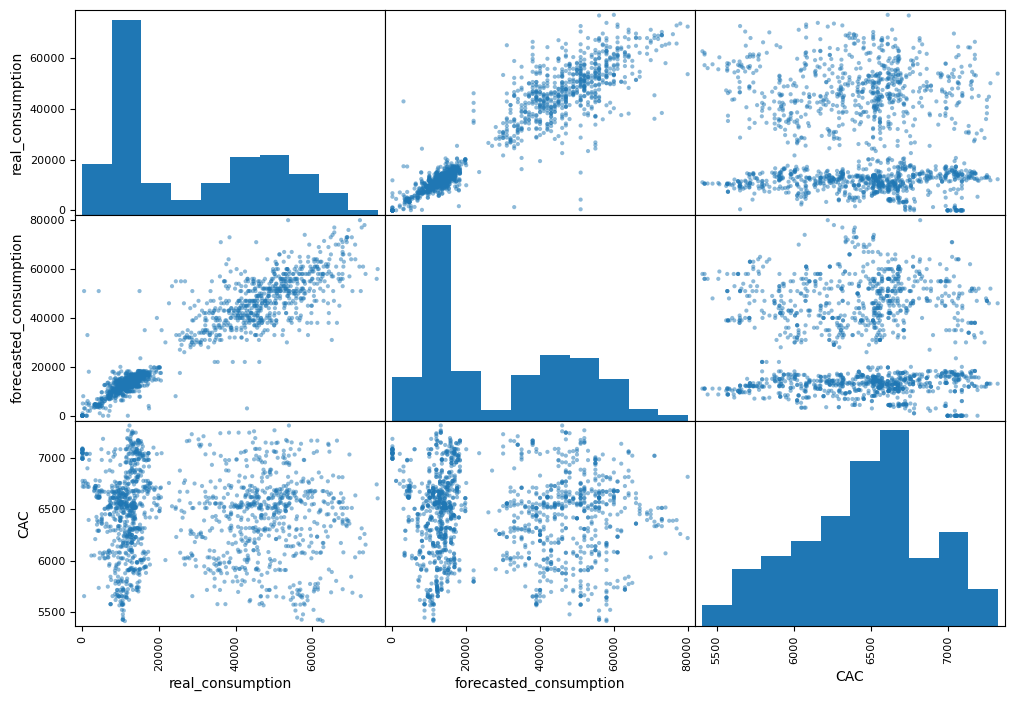

In [ ]:
attributes = ["real_consumption","forecasted_consumption", "CAC"]

axes = pd.plotting.scatter_matrix(pd.concat([data.groupby("id_client").get_group(6), data.groupby("id_client").get_group(4)])[attributes], figsize=(12, 8))
"""
# Masquer les sous-parcelles sauf la première ligne
for i, row in enumerate(axes):
    if i == 0 : 
        for j, subplot in enumerate(row) : 
            subplot.set_xlabel(attributes[j])
    else :
        for subplot in row : 
            subplot.set_visible(False)
"""
# Afficher la matrice de dispersion
plt.show()

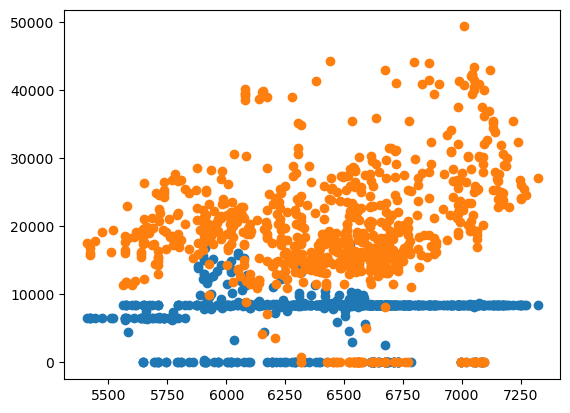

In [6]:
import matplotlib.pyplot as plt

# Créer une figure
fig, ax = plt.subplots()

# Itérer sur les valeurs uniques de id_client
for id_client in data["id_client"].unique()[:2]:
    # Filtrer les données pour le id_client actuel
    filtered_data = data[data["id_client"] == id_client]
    
    # Tracer la courbe pour le id_client actuel
    ax.scatter(filtered_data["CAC"], filtered_data["real_consumption"], label=f"id_client {id_client}")

# Afficher le graphe
plt.show()

/opt/miniconda3/envs/data/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


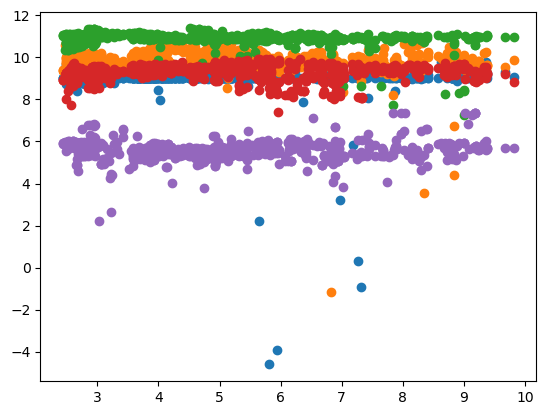

In [7]:
import matplotlib.pyplot as plt

# Créer une figure
fig, ax = plt.subplots()

# Itérer sur les valeurs uniques de id_client
for id_client in data["id_client"].unique()[:5]:
    # Filtrer les données pour le id_client actuel
    filtered_data = data[data["id_client"] == id_client]
    
    # Tracer la courbe pour le id_client actuel
    ax.scatter(filtered_data["gasNat"],np.log(filtered_data["real_consumption"]), label=f"id_client {id_client}")

# Afficher le graphe
plt.show()

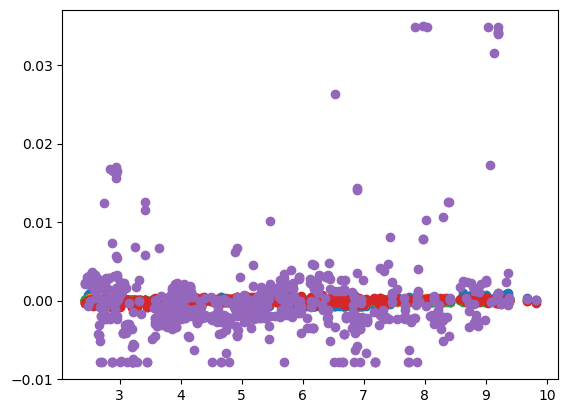

In [8]:
import matplotlib.pyplot as plt

# Créer une figure
fig, ax = plt.subplots()

# Itérer sur les valeurs uniques de id_client
for id_client in data["id_client"].unique()[:5]:
    # Filtrer les données pour le id_client actuel
    filtered_data = data[data["id_client"] == id_client]
    
    # Tracer la courbe pour le id_client actuel
    ax.scatter(filtered_data["gasNat"],(filtered_data["real_consumption"] - filtered_data["real_consumption"].mean())/(filtered_data["real_consumption"].std()**2), label=f"id_client {id_client}")

# Afficher le graphe
plt.show()

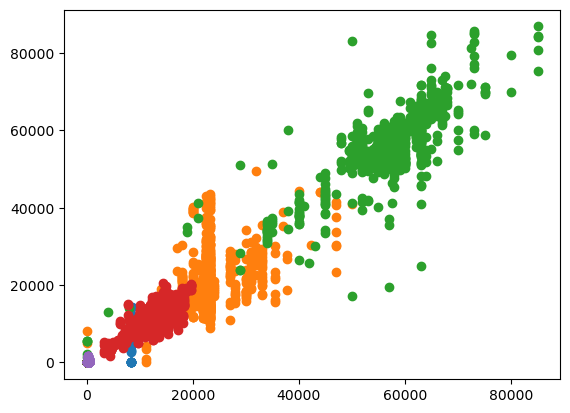

In [9]:
import matplotlib.pyplot as plt

# Créer une figure
fig, ax = plt.subplots()

# Itérer sur les valeurs uniques de id_client
for id_client in data["id_client"].unique()[:5]:
    # Filtrer les données pour le id_client actuel
    filtered_data = data[data["id_client"] == id_client]
    
    # Tracer la courbe pour le id_client actuel
    ax.scatter(filtered_data["forecasted_consumption"],filtered_data["real_consumption"], label=f"id_client {id_client}")

# Afficher le graphe
plt.show()

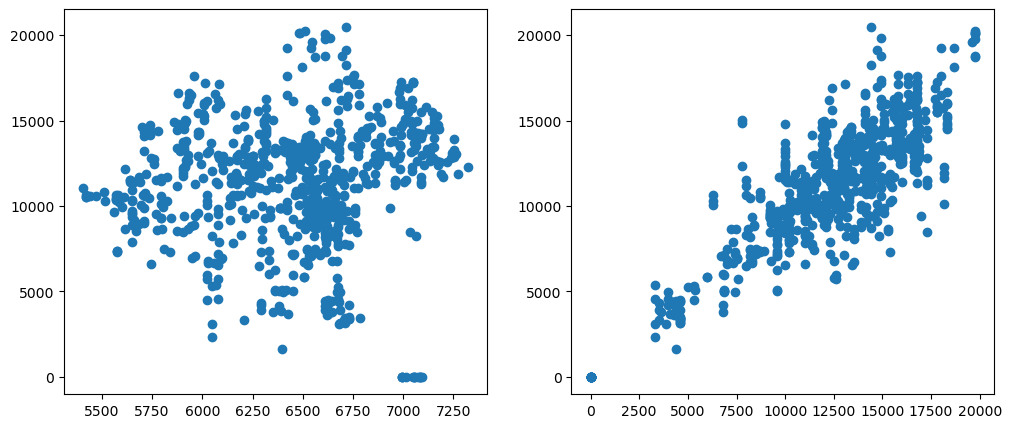

In [10]:
import matplotlib.pyplot as plt

# Créer une figure
fig, ax = plt.subplots(1,2, figsize = (12,5))

# Itérer sur les valeurs uniques de id_client
#for id_client in data["id_client"].unique()[6]:
    # Filtrer les données pour le id_client actuel
filtered_data = data[data["id_client"] ==4]
    
    # Tracer la courbe pour le id_client actuel
ax[0].scatter(filtered_data["CAC"],filtered_data["real_consumption"], label=f"id_client {id_client}")
ax[1].scatter(filtered_data["forecasted_consumption"],filtered_data["real_consumption"], label=f"id_client {id_client}")

# Afficher le graphe
plt.show()

In [11]:
data[data["id_client"] == 11]["forecasted_consumption"].unique()

array([850., 750., 833.,   0.])

In [12]:
client_pourri = []
for i in data["id_client"].unique(): 
    if len(data[data["id_client"] == i]["forecasted_consumption"].unique()) < 15 :
        client_pourri.append(i)

In [13]:
 client_pourri

[1,
 5,
 11,
 12,
 13,
 14,
 16,
 19,
 24,
 25,
 26,
 27,
 29,
 30,
 31,
 32,
 34,
 35,
 36,
 37,
 46,
 47]

In [14]:
data = data[~(data["id_client"].isin(client_pourri))]

In [15]:
data["id_client"].unique()

array([ 2,  3,  4,  6,  7, 10, 15, 18, 20, 21, 22, 33, 39, 40, 41, 42, 43,
       44, 45, 48])

In [16]:
#Model1 (brut): 
model1, eval_model1 = complet_process(data, ["id_client", "forecasted_consumption", "gasNat"], ["real_consumption"],0.66, group = False, random_forest = False , n_estimators = 150)

#Model2 (avec CAC)
model2, eval_model2 = complet_process(data, ["id_client", "forecasted_consumption", "CAC"], ["real_consumption"],0.66, group = False, random_forest = False, n_estimators = 150)

#Model3 (avec CAC, STOXX, AEX, BFX)
model3, eval_model3 = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "STOXX", "AEX", "BFX"], ["real_consumption"], 0.72, group = False, random_forest = False , n_estimators = 150)

#Model4 (avec CAC, STOXX, AEX, BFX, airliquide) 
model4, eval_model4 = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "STOXX", "AEX", "BFX", "Airliquide"], ["real_consumption"], 0.72, group = False, random_forest = False , n_estimators = 150)

#Model5 (avec CAC, gasNat) 
model5, eval_model5 = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "gasNat"], ["real_consumption"], 0.66, group = False, random_forest = False , n_estimators = 150)

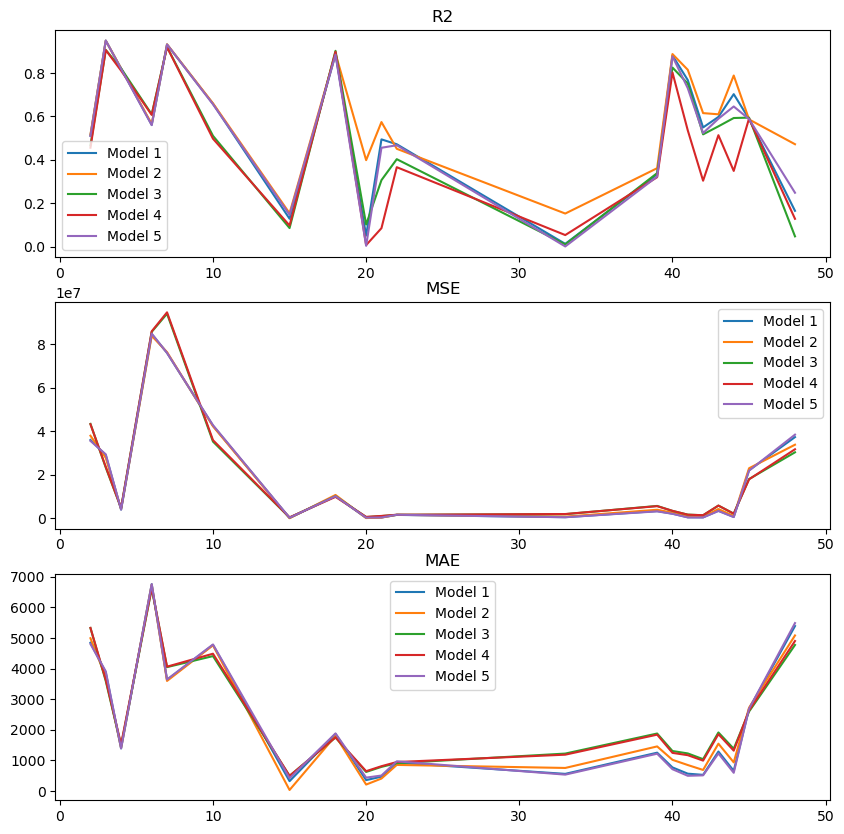

In [17]:
display_mesure(data, [eval_model1, eval_model2, eval_model3, eval_model4, eval_model5], [f"Model {i}" for i in range(1,6)]);

In [18]:
tab_mesure(eval_model2).describe()

,R2,MSE,MAE
count,20.000000,2.000000e+01,20.000000
mean,0.610030,1.779448e+07,2181.252025
std,0.238207,2.554216e+07,1952.791323
min,0.152094,1.684600e+03,35.633421
25%,0.466586,8.052811e+05,827.075823
50%,0.598045,4.045598e+06,1436.864674
75%,0.816805,2.929581e+07,3629.951625
max,0.949413,8.389877e+07,6743.312401


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
lim_date = 0.66
df = data.copy()
xargs = ["id_client", "forecasted_consumption", "CAC"]
yargs = ["real_consumption"]
model1, eval_model1 = complet_process(data, ["id_client", "forecasted_consumption", "CAC"], ["real_consumption"],0.66, group = False, random_forest = False , n_estimators = 150)
train_size = int(
    len(df.groupby("id_client").get_group(df["id_client"].unique()[0])) * lim_date
)
date_lim = (
    df.groupby("id_client")
    .get_group(df["id_client"].unique()[0])["horodate"][:train_size]
    .iloc[-1]
)

train = df[df["horodate"] <= date_lim]
test = df[df["horodate"] > date_lim]
X_test = test.copy()[xargs]
Y_test = test.copy()[yargs]

# Calcul de l'importance des variables par permutation
result = permutation_importance(model1, X_test, Y_test, n_repeats=100, random_state=42)

# Récupération des scores d'importance
importance_scores = result.importances_mean

# Affichage des scores d'importance par variable
for i, score in enumerate(importance_scores):
    print("Variable", i, ":", score)

Variable 0 : 0.0017875308171793624
Variable 1 : 1.9836505806981253
Variable 2 : 7.998609222940045e-06


In [20]:
permutation_feature_importance(data, ["id_client", "forecasted_consumption", "CAC"], ["forecasted_consumption"], 0.66)

array([0.        , 1.99925686, 0.        ])

In [21]:
model, eval_model = complet_process(
        df, xargs, yargs, lim_date, False, False, 150
    )

train_size = int(
    len(df.groupby("id_client").get_group(df["id_client"].unique()[0])) * lim_date
)

date_lim = (
    df.groupby("id_client")
    .get_group(df["id_client"].unique()[0])["horodate"][:train_size]
    .iloc[-1]
)
train = df[df["horodate"] <= date_lim]
test = df[df["horodate"] > date_lim]
X_test = test.copy()[xargs]
Y_test = test.copy()[yargs]

result = permutation_importance(
    model, X_test, Y_test, n_repeats=100, random_state=42
)

# Récupération des scores d'importance
importance_scores = result.importances_mean
importance_scores

array([1.78753082e-03, 1.98365058e+00, 7.99860922e-06])

In [22]:
lim_date = 0.66
df = data.copy()
xargs = ["id_client", "forecasted_consumption", "CAC"]
yargs = ["real_consumption"]
n = df["id_client"].max()
random_forest = False

train_size = int(
    len(df.groupby("id_client").get_group(df["id_client"].unique()[0])) * lim_date
)
date_lim = (
    df.groupby("id_client")
    .get_group(df["id_client"].unique()[0])["horodate"][:train_size]
    .iloc[-1]
)
train = df[df["horodate"] <= date_lim]
test = df[df["horodate"] > date_lim]
X_train = train.copy()[xargs]
Y_train = train.copy()[yargs]
X_test = test.copy()[xargs]
Y_test = test.copy()[yargs]

# création du model
if random_forest:
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
else:
    model = LinearRegression()
model.fit(X_train, np.array(Y_train).ravel())
y_pred = model.predict(X_test)

comp = pd.DataFrame(Y_test.copy())
comp["pred"] = y_pred
comp["id_client"] = X_test["id_client"]
evaluation_model = []

evaluation_model = []
for i in df["id_client"].unique():
    y = comp.groupby("id_client").get_group(i)["pred"]
    y2 = np.array(comp.groupby("id_client").get_group(i)[yargs]).ravel()
    evaluation_model.append(metrics(y2, y))

In [38]:
data = import_data()

def set_up_index(index): 
    index.rename({"Date": "horodate"}, axis = 1, inplace = True)
    index["horodate"] = pd.to_datetime(index["horodate"])
    index.set_index("horodate", inplace = True)
    index = index.asfreq("D")
    index.reset_index(inplace = True)
    index = index.fillna(method = "ffill")
    date = (index["horodate"] >= pd.to_datetime("2021-01-01")) & (index["horodate"] <= pd.to_datetime("2023-01-31"))
    index = index[date]
    index.reset_index(inplace = True)
    index = index[["horodate", "Open"]]
    return index 

CAC = pd.read_csv("../data/^FCHI.csv")
AEX = pd.read_csv("../data/^AEX.csv")
BFX = pd.read_csv("../data/^BFX.csv")
STOXX = pd.read_csv("../data/^STOXX50E.csv")
Airliquide = pd.read_csv("../data/AI.PA.csv")
gasNat = pd.read_csv("../data/gasNat.csv").rename({"Ouvert": "Open"}, axis = 1)

CAC = set_up_index(CAC)
AEX = set_up_index(AEX)
BFX = set_up_index(BFX)
STOXX = set_up_index(STOXX)
Airliquide = set_up_index(Airliquide)
gasNat = set_up_index(gasNat)

CAC.rename({"Open": "CAC"}, axis = 1, inplace = True)
AEX.rename({"Open": "AEX"}, axis = 1, inplace = True)
BFX.rename({"Open": "BFX"}, axis = 1, inplace = True)
STOXX.rename({"Open": "STOXX"}, axis = 1, inplace = True)
Airliquide.rename({"Open": "Airliquide"}, axis = 1, inplace = True)
gasNat.rename({"Open": "gasNat"}, axis = 1, inplace = True)

#CAC.rename({"Volume": "CAC"}, axis = 1, inplace = True)
#AEX.rename({"Volume": "AEX"}, axis = 1, inplace = True)
#BFX.rename({"Volume": "BFX"}, axis = 1, inplace = True)
#STOXX.rename({"Volume": "STOXX"}, axis = 1, inplace = True)

# il faut merge avec le tableau principal
data = pd.merge(data, CAC, on = ["horodate"], how = "left")
data = pd.merge(data, AEX, on = ["horodate"], how = "left")
data = pd.merge(data, BFX, on = ["horodate"], how = "left")
data = pd.merge(data, STOXX, on = ["horodate"], how = "left")
data = pd.merge(data, Airliquide, on = ["horodate"], how = "left")
data = pd.merge(data, gasNat, on = ["horodate"], how = "left")
n = data["id_client"].max()
test_data = data[data["horodate"] > pd.to_datetime("2022-08-31")]

data = data[~(data["id_client"].isin([8,9, 17, 23, 28, 37, 38 , 49]))]

In [39]:
model1, eval_model1 = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "gasNat"], ["real_consumption"], 0.66, group = False, random_forest = False , n_estimators = 150)